In [208]:
import pandas as pd
import matplotlib.pyplot as plt
from utils import *

sp500 = pd.read_csv('data/SP500_mine.csv')
sp500 = process_data(sp500)

In [209]:
# 변수 설정
var_confidence = 0.5
window = 400

In [210]:
# trix 구현
sp500['trix'] = calculate_trix(sp500['Price'], n=5)
sp500 = set_signal(sp500)

In [211]:
# rf 추가
rf = pd.read_csv('data/rf_data.csv')
rf.columns = ['Date', 'rf']
rf = calculate_daily_rf(rf, 250)
sp500 = sp500.join(rf)
sp500['rf'] = sp500['rf'].ffill()

In [212]:
# VaR 계산
sp500_var = get_historical_var(sp500, window, var_confidence)

In [213]:
# Kelly 계산
sp500_var['kelly'] = get_rolling_kelly(sp500_var)

In [214]:
# 정해둔 시점에 대한 값만 겟
index_location = sp500_var.index.get_loc('01/08/2009')
sp500_target = sp500_var.iloc[index_location+1:]

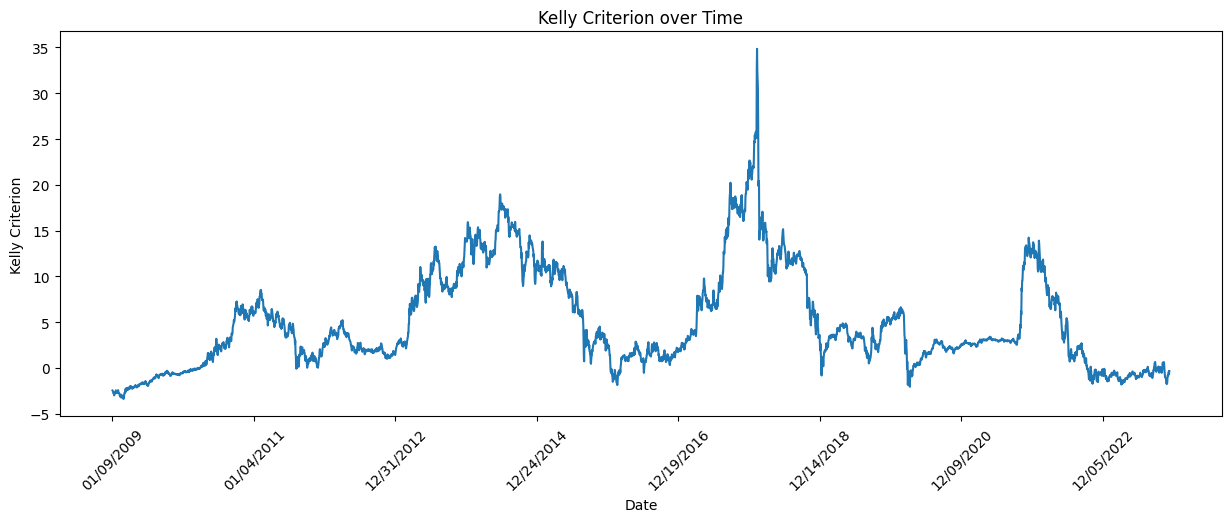

In [215]:
plt.figure(figsize=(15,5))
sp500_target['kelly'].plot()
plt.title('Kelly Criterion over Time')
plt.ylabel('Kelly Criterion')
plt.xticks(rotation = 45)

plt.savefig(f'trix_result/Kelly_window_{str(window)}.png')

In [216]:
# kelly 범위 조정
sp500_target.loc[:, 'kelly_ratio'] = sp500_target['kelly'].apply(lambda x: calculate_capped_kelly(x))

/var/folders/yz/s1q6x0ws0mq8fpv7l4vlz9_c0000gn/T/ipykernel_11529/2063448813.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp500_target.loc[:, 'kelly_ratio'] = sp500_target['kelly'].apply(lambda x: calculate_capped_kelly(x))


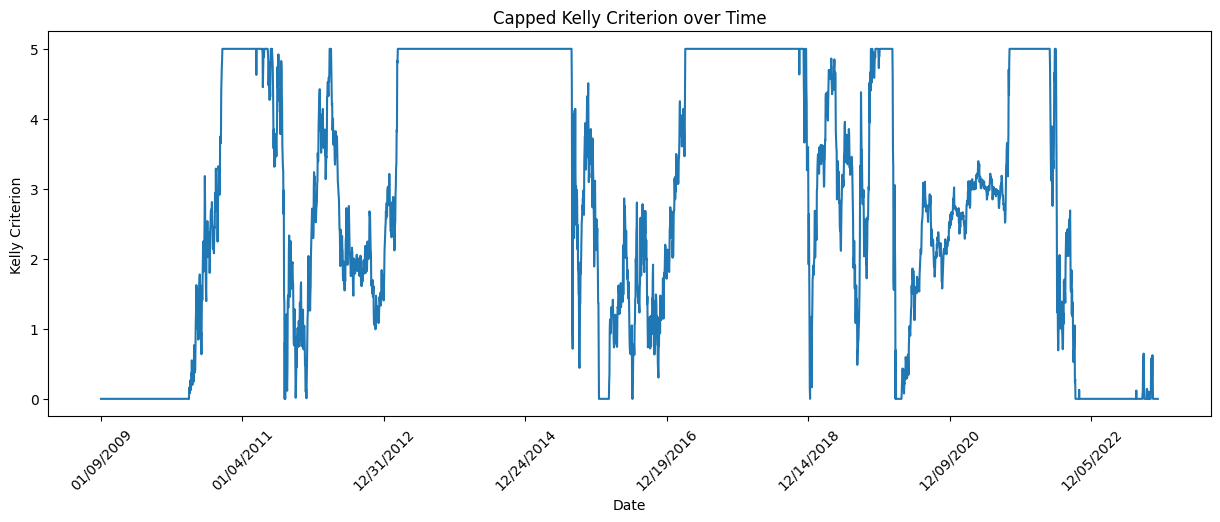

In [217]:
plt.figure(figsize=(15,5))
sp500_target['kelly_ratio'].plot()
plt.title('Capped Kelly Criterion over Time')
plt.ylabel('Kelly Criterion')
plt.xticks(rotation = 45)

plt.savefig(f'trix_result/Capped_kelly_window_{str(window)}.png')

In [218]:
# VaR 적용
sp500_result_var_kelly = sp500_target.copy()
sp500_result_var_kelly['kelly_ratio'] = sp500_result_var_kelly.apply(lambda row: update_var_kelly(row), axis=1)

In [219]:
# 수익률 계산
sp500_result = get_cumulative_trix_returns(sp500_target)
sp500_result_var_kelly = get_cumulative_trix_returns(sp500_result_var_kelly)

/Users/kimjihyo/Documents/GitHub/The-Kelly-Criterion/utils.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'portfolio'] = portfolio
/Users/kimjihyo/Documents/GitHub/The-Kelly-Criterion/utils.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'equity'] = equity
/Users/kimjihyo/Documents/GitHub/The-Kelly-Criterion/utils.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

In [220]:
sp500_result_var_kelly.to_csv(f'trix_result/All_marks_var_{str(var_confidence)}, window_{str(window)}.csv')

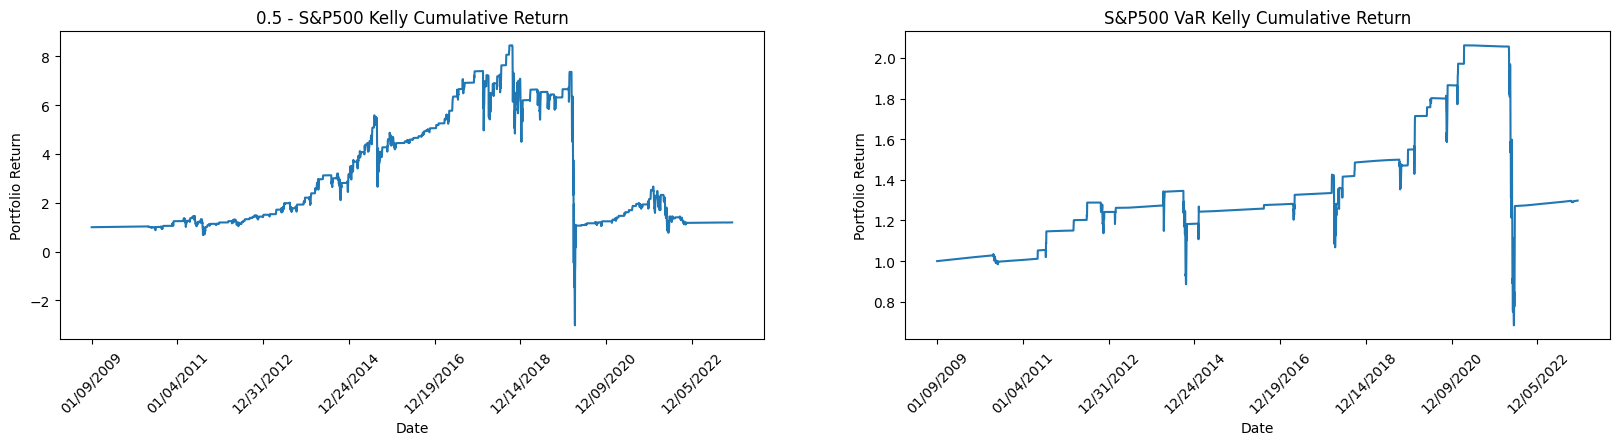

In [221]:
fig, ax = plt.subplots(ncols=2, figsize=(20, 4))

sp500_result['portfolio'].plot(ax=ax[0])
ax[0].set_ylabel('Portfolio Return');
ax[0].tick_params(axis='x', rotation=45);
ax[0].set_title(f'{str(var_confidence)} - S&P500 Kelly Cumulative Return');

sp500_result_var_kelly['portfolio'].plot(ax=ax[1])
ax[1].set_ylabel('Portfolio Return');
ax[1].tick_params(axis='x', rotation=45);
ax[1].set_title('S&P500 VaR Kelly Cumulative Return');

plt.savefig(f'trix_result/Returns_var_{str(var_confidence)}, window_{str(window)}.png')

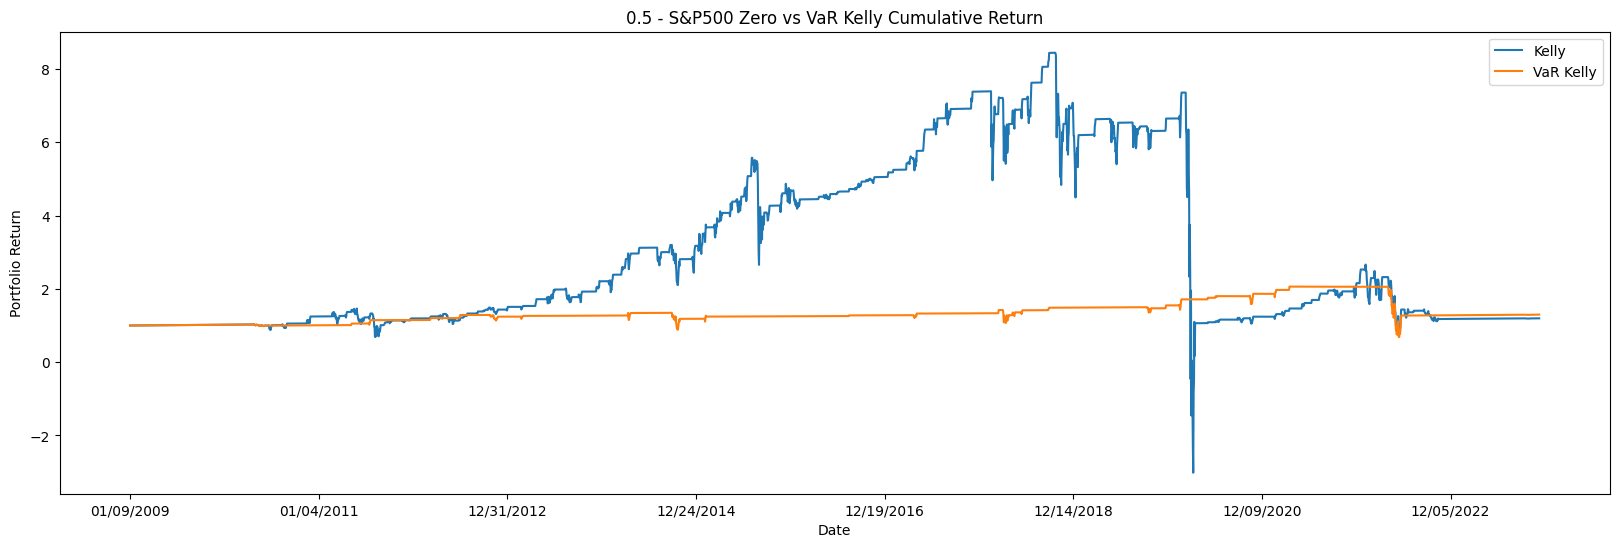

In [222]:
fig, ax = plt.subplots(figsize=(20, 6))

sp500_result['portfolio'].plot(ax=ax, label='Kelly')
sp500_result_var_kelly['portfolio'].plot(ax=ax, label='VaR Kelly')

ax.set_ylabel('Portfolio Return')
ax.set_title(f'{str(var_confidence)} - S&P500 Zero vs VaR Kelly Cumulative Return')
ax.legend()

plt.savefig(f'trix_result/Combined_Returns_var_{str(var_confidence)}, window_{str(window)}.png')

In [223]:
sp500_target['cumulative_return'] = (1+sp500_target['Change']).cumprod()

/var/folders/yz/s1q6x0ws0mq8fpv7l4vlz9_c0000gn/T/ipykernel_11529/767642306.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp500_target['cumulative_return'] = (1+sp500_target['Change']).cumprod()


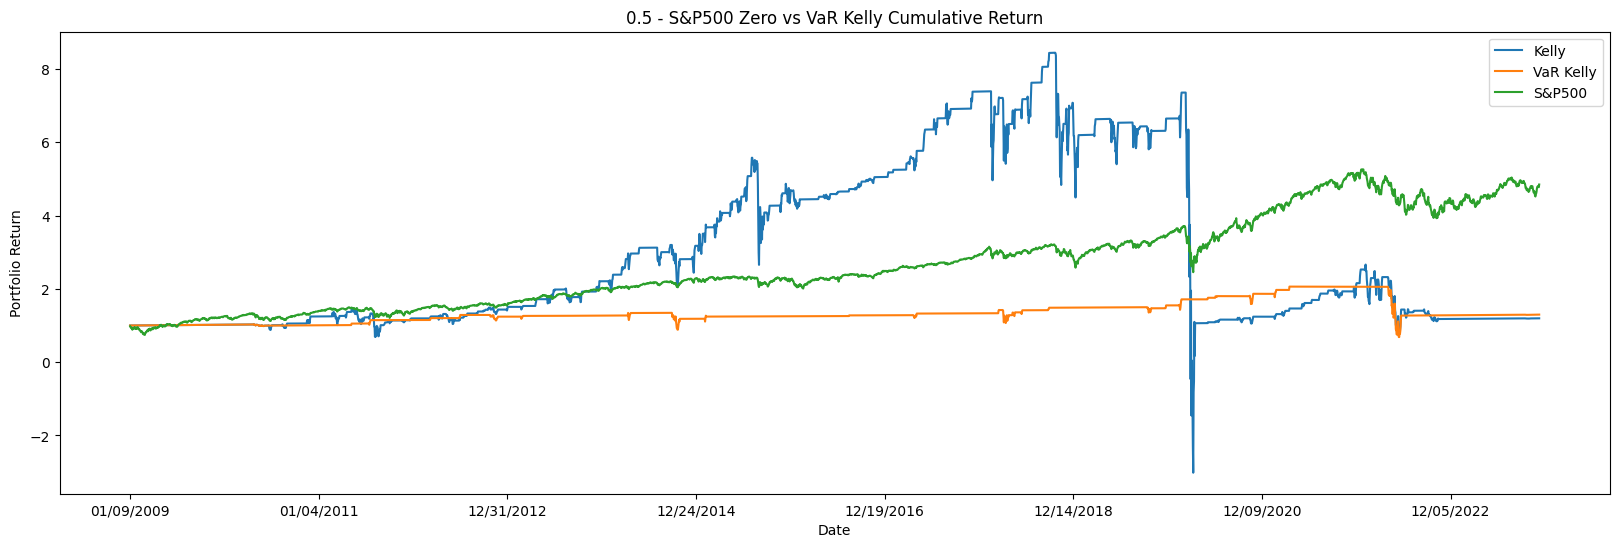

In [224]:
fig, ax = plt.subplots(figsize=(20, 6))

sp500_result['portfolio'].plot(ax=ax, label='Kelly')
sp500_result_var_kelly['portfolio'].plot(ax=ax, label='VaR Kelly')
sp500_target['cumulative_return'].plot(ax=ax, label='S&P500')

ax.set_ylabel('Portfolio Return')
ax.set_title(f'{str(var_confidence)} - S&P500 Zero vs VaR Kelly Cumulative Return')
ax.legend()

plt.savefig(f'trix_result/Combined_All_Returns_var_{str(var_confidence)}, window_{str(window)}.png')